### A/334 Parameter Specification
- Autocorrection Delay = 3ms
- Sysmbol interval T = 1/106 seconds
- Marking Frequency Band = 2.5kHz - 5.0kHz

### Sample 
- frequency 48kHz -> 48000 frames/second
- Symbol frames 48000/106 = ca. 453 frames

### Help


In [1]:
import wave
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from scipy.signal import butter, lfilter

In [2]:
with wave.open('audio.wav', 'rb') as w:
    samplerate = w.getframerate()
    frames = w.getnframes()
    channels = w.getnchannels()
    width = w.getsampwidth()
    print('sampling rate:', samplerate, 'Hz')
    print('length:', frames, 'samples')
    print('channels:', channels)
    print('sample width:', width, 'bytes')
    
    data = w.readframes(frames)


sampling rate: 48000 Hz
length: 14880384 samples
channels: 2
sample width: 2 bytes


In [3]:
print(2*2*14880384) #channels * sample width * sample length = 59521536 bytes buffersize
print(len(data))
type(data)

59521536
59521536


bytes

In [4]:
sig = np.frombuffer(data, dtype='<i2').reshape(-1, channels)
offset_sec = 0.003
offset_frames = int(samplerate * offset_sec)
symbols_per_sec = 106
samples_per_symbol = samplerate / symbols_per_sec
samples_per_symbol

452.8301886792453

In [5]:
#https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [6]:
sig_bandpassed = butter_bandpass_filter(sig[:, 0], 2500, 5000, samplerate)

c:\Users\timm-\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


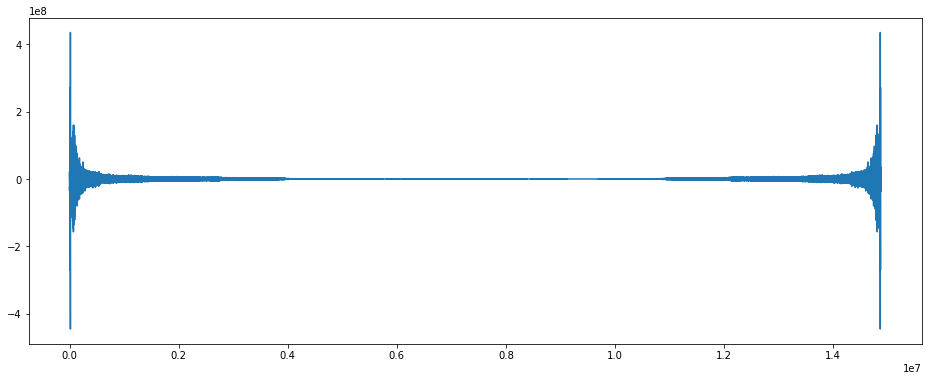

In [7]:
sig_fft = np.fft.fft(sig[:, 0])

plt.figure(figsize=(16, 6))
plt.plot(sig_fft)

c:\Users\timm-\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


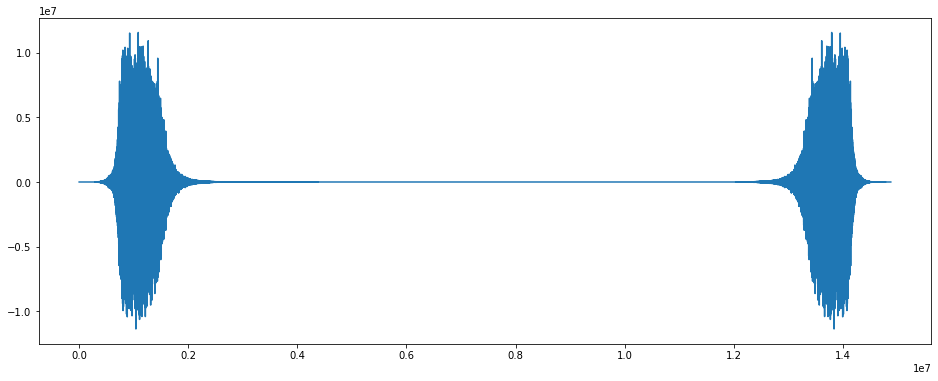

In [8]:
sig_fft = np.fft.fft(sig_bandpassed)

plt.figure(figsize=(16, 6))
plt.plot(sig_fft)

c:\Users\timm-\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


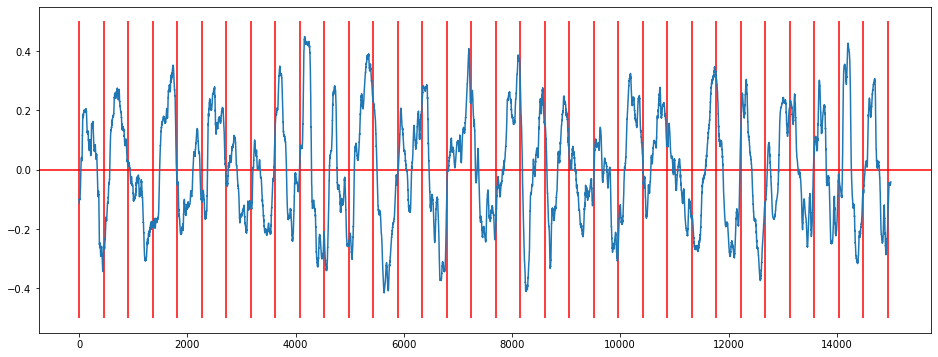

In [46]:
samples = 15000
sigg = sig_bandpassed
diffs = np.zeros(samples)
for i in range(samples):
    orig_acf = acf(sigg[i:int(samples_per_symbol)+i], nlags=offset_frames)
    delay_acf = acf(sigg[offset_frames+i:offset_frames+i+int(samples_per_symbol)], nlags=offset_frames)
    # Sollte es nicht so sein?
    # orig_acf = acf(sigg[i:int(samples_per_symbol/2)+i], nlags=offset_frames)
    # delay_acf = acf(sigg[i+int(samples_per_symbol/2):i+int(samples_per_symbol)], nlags=offset_frames)
    diffs[i] = orig_acf[-1] - delay_acf[-1]

plt.figure(figsize=(16, 6))
plt.vlines(np.arange(0,samples, samples_per_symbol), -0.5, 0.5, colors=["red"])
plt.axhline(y=0, color='r', linestyle='-')
plt.plot(diffs, '-')


In [58]:
MESSAGE_HEADER = '10101110000010101011100111100100'
MESSAGE_HEADER = '1010111000'
for i in range(20* int(samples_per_symbol)):
    is_correct = True
    for j in range(len(MESSAGE_HEADER)):
        if not (diffs[int(j*samples_per_symbol+i)] >= 0 and MESSAGE_HEADER[j] == '1' or diffs[int(j*samples_per_symbol+i)] < 0 and MESSAGE_HEADER[j] == '0'):
            is_correct = False
            break
    if is_correct:
        print(f"found offset for message start {i}", i)      

found offset for message start 5112 5112
found offset for message start 5113 5113
found offset for message start 5119 5119
found offset for message start 6345 6345
found offset for message start 6346 6346
found offset for message start 6347 6347


In [48]:
15000 / samples_per_symbol

33.125